# same as 02b but getting precip values as outputs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import xcdat as xc
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

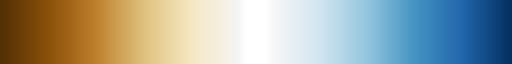

In [5]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [6]:
import os

In [7]:
model_list = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[1:]
# model_list2 = sorted(os.listdir('/scratch/ob22/as8561/data/preproc/'))[18:]
model_list#.extend(model_list2)

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'CESM2',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL',
 'obs',
 'rean']

In [8]:
len(model_list)

32

In [9]:
import climtas
from scipy import stats
# import seaborn as sns
import pandas as pd
from dateutil.relativedelta import relativedelta
import regionmask

def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    da['time'] = pd.date_range('1891-01-01', '2015-01-01', freq='1M')

    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    # custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    # time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


def calc_anom(
    input_da,
    base_start_date: str = "1960-01-01",
    base_end_date: str = "1990-01-01",
    start_year: str = "1891-01-01",
    end_year: str = "2015-01-01",
    # var = "Temperature",
    # units = 'K'
):

    # define the base climatology
    base_clim = input_da.sel(time=slice(base_start_date, base_end_date))

    # calculate the monthly climatology for the base years
#     da_clim_coarsen = base_clim.coarsen(time=12)
    da_clim = base_clim.groupby("time.month").mean("time")
    da_anom = input_da.sel(time = slice(start_year, end_year)).groupby("time.month") - da_clim
    
    return da_anom

####

In [45]:
# Function to preprocess the regridded data


import xarray as xr
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk

def detrend1d(arr, period = 9*12):
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det
    
def detrend1d_check(arr, period = 9):
    # if np.nansum(arr) != 0:
    #     trend = mk.hamed_rao_modification_test(arr).trend
    # else:
    #     trend = 'no trend'
    # if trend != 'no trend':
    #     res = STL(arr, period = period).fit()
    #     arr_det = arr - res.trend
    #     return arr_det
    # else:
    #     return arr
    res = STL(arr, period = period).fit()
    arr_det = arr - res.trend
    return arr_det

# def detrend_separate(da, period=9):
#     trend = da.rolling(time = period*12).mean('time')
#     da_detrend = da - trend
#     return da_detrend
def detrend_separate(da, dim):
    return xr.apply_ufunc(detrend1d, da, input_core_dims=[[dim]], output_core_dims=[[dim]])
    
def detrend_separate_check(da, dim):
    return xr.apply_ufunc(detrend1d_check, da, input_core_dims=[[dim]], output_core_dims=[[dim]])

In [11]:
def extract_results_parallel(var, nino34):
    weights = np.cos(np.deg2rad(var.lat))
    weights.name = 'weights'
    # reorder the vars
    var = var.weighted(weights).mean(('lat', 'lon'))
    return var.to_numpy(), nino34.to_numpy()


def calc_data_res_parallel(params):
    base_loc = '/scratch/ob22/as8561/data/preproc/'
    model = params[0]
    region = params[1]
    # get all the data
    precip = xr.open_dataset(base_loc + f'{model}/precip.nc').precip#.load()
    precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
    precip_anom = precip.sortby(precip.lon)
    #
    nino34 = xr.open_dataset(base_loc + f'{model}/nino.nc').nino#.load()
    # mask the land area firt
    land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False, drop=False)
    precip_land = precip.where(land_mask.isel(region=0))
    # mask for the ar6 land regions
    ar6_mask = regionmask.defined_regions.ar6.land.mask_3D(precip_land, wrap_lon=False, drop=False)
    # ar6_list = regionmask.defined_regions.ar6.land.to_dataframe()['names'].to_numpy()
    out_precip, out_nino = extract_results_parallel(precip_land.where(ar6_mask.isel(region=region)), nino34)
    return out_precip, out_nino

In [12]:
from multiprocessing import Pool
import itertools

In [13]:
region_list = regionmask.defined_regions.ar6.land.to_dataframe().index.to_numpy()

In [14]:
param_arr = [model_list, region_list]

In [14]:
param_list = list(itertools.product(*param_arr))

In [16]:
name_list = ['precip', 'nino']

In [17]:
len(name_list)

2

In [18]:
time = xr.open_dataset('/scratch/ob22/as8561/data/preproc/ACCESS-CM2/precip.nc').time.to_numpy()
time

array(['1891-01-16T12:00:00.000000000', '1891-02-15T00:00:00.000000000',
       '1891-03-16T12:00:00.000000000', ...,
       '2014-10-16T12:00:00.000000000', '2014-11-16T00:00:00.000000000',
       '2014-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
def convert_to_da(arr, name):
    return xr.DataArray(
        data = arr,
        dims = ["time", "region", "model"],
        coords = dict(
            time = (["time"], time),
            region = (["region"], region_list),
            model = (["model"], model_list),
        ),
        name = name
    )

# def convert_to_da_base(arr, name):
#     return xr.DataArray(
#         data = arr,
#         dims = ["season", "region", "model"],
#         coords = dict(
#             season = (["season"], ['djf', 'jja', 'mam', 'son']),
#             region = (["region"], region_list),
#             model = (["model"], model_list),
#         ),
#         name = name
#     )

In [20]:
res_arr = []
with Pool() as pool:
    i = 0
    for res in pool.imap(calc_data_res_parallel, param_list):
        res_arr.append(res)
        print(f'completed {i+1}/{46*32}', end='\r')
        i += 1

In [21]:
# res_arr = np.array(res_arr)
da_arr = []
precip_arr = np.empty((1488, 1472))
nino_arr = np.empty((1488, 1472))
# base_arr = np.empty((4, 1472))

for i in range(1472):
    precip_arr[:, i] = np.array(res_arr)[:, 0][i]
    nino_arr[:, i] = np.array(res_arr)[:, 1][i]
    # base_arr[:, i] = np.array(res_arr)[:, 2][i]
    
da_precip = convert_to_da(np.reshape(precip_arr, (1488, 46, 32), order = 'F'), name_list[0])
da_nino = convert_to_da(np.reshape(nino_arr, (1488, 46, 32), order = 'F'), name_list[1])
# da_base = convert_to_da_base(np.reshape(base_arr, (4, 46, 32), order = 'F'), name_list[2])

In [22]:
ds=xr.merge([da_precip, da_nino])

In [26]:
ds.isel(model=-2, region=-3).precip

<xarray.DataArray 'precip' (time: 1488)>
array([167.72695363, 168.74524808, 137.67365607, ..., 174.96245041,
       198.85901959, 168.85605877])
Coordinates:
  * time     (time) datetime64[ns] 1891-01-16T12:00:00 ... 2014-12-16T12:00:00
    region   int64 43
    model    <U16 'obs'

In [27]:
ds.to_netcdf('./PhD/enso_precip_asymmetry/data/result/out1.nc')

In [28]:
ds

<xarray.Dataset>
Dimensions:  (time: 1488, region: 46, model: 32)
Coordinates:
  * time     (time) datetime64[ns] 1891-01-16T12:00:00 ... 2014-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model    (model) <U16 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Data variables:
    precip   (time, region, model) float64 49.98 29.4 28.28 ... 26.33 nan 19.94
    nino     (time, region, model) float64 nan nan nan ... -0.5921 1.018 1.018

### start here

In [15]:
out = xc.open_dataset('./PhD/enso_precip_asymmetry/data/result/out1.nc', add_bounds=True)
out

<xarray.Dataset>
Dimensions:    (time: 1488, region: 46, model: 32, bnds: 2)
Coordinates:
  * time       (time) object 1891-01-16 12:00:00 ... 2014-12-16 12:00:00
  * region     (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * model      (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'obs' 'rean'
Dimensions without coordinates: bnds
Data variables:
    precip     (time, region, model) float64 ...
    nino       (time, region, model) float64 ...
    time_bnds  (time, bnds) object 1891-01-01 18:00:00 ... 2014-12-31 18:00:00

In [16]:
# one_region

In [17]:
import seaborn as sns

<Axes: ylabel='Density'>

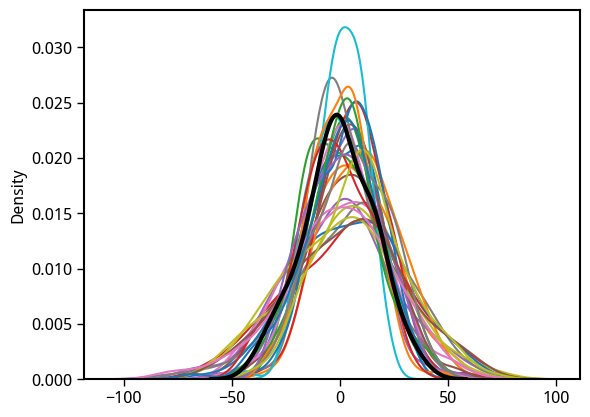

In [18]:
jja = out.isel(region=37, model=-2).precip.time.dt.month.isin([6,7,8])
for model in range(0,32,1):
    if model != 13:
        pr = detrend_separate_check(calc_anom(out.isel(region=37, model=model).precip).sel(time=jja).groupby('time.year').mean('time'), 'year')
        sns.kdeplot(pr)
pr = detrend_separate_check(calc_anom(out.isel(region=37, model=-2).precip).sel(time=jja).groupby('time.year').mean('time'), 'year')
sns.kdeplot(pr,color='k', lw=3.0)

In [19]:
naus  = out.isel(region=39, model = -2)
naus

<xarray.Dataset>
Dimensions:    (time: 1488, bnds: 2)
Coordinates:
  * time       (time) object 1891-01-16 12:00:00 ... 2014-12-16 12:00:00
    region     int64 39
    model      <U3 'obs'
Dimensions without coordinates: bnds
Data variables:
    precip     (time) float64 ...
    nino       (time) float64 ...
    time_bnds  (time, bnds) object 1891-01-01 18:00:00 ... 2014-12-31 18:00:00

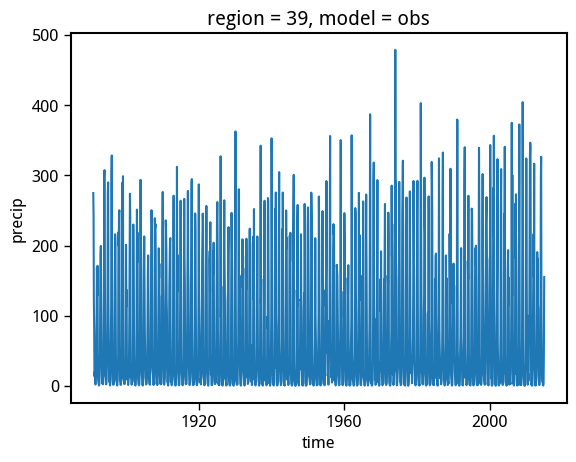

In [20]:
naus.precip.plot()

In [51]:
def calc_res(precip, nino34, season_str):
    precip_anom = calc_anom(precip)
    threshold = float(nino34.std())
    # nino34 = reorder(nino34).sel(time = sondjf).groupby('time.year').mean('time')[:-1]
    if season_str == 'ANN':
        precip_clim = float(reorder(precip).groupby('time.year').mean('time').mean('year'))
        precip_std = float(reorder(precip).groupby('time.year').mean('time').std('year'))
        precip_det = detrend_separate_check(reorder(precip_anom).groupby('time.year').mean('time'), dim='year').sel(year = slice('1892', '2015'))
        nino34 = reorder(nino34).groupby('time.year').mean('time').sel(year = slice('1892', '2015'))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        enc = nino - neut
        lnc = nina - neut
        asymm = (enc + lnc)/2
    else:
        season_names = ['DJF', 'MAM', 'JJA', 'SON']
        season_months = [[12,1,2], [3,4,5], [6,7,8], [9,10,11]]
        season_dict = dict(zip(season_names, season_months))
        season_month = season_dict[season_str]
        season = precip_anom.time.dt.month.isin(season_month)
        precip_clim = float(precip.groupby('time.season').mean('time').sel(season = season_str))
        precip_std = float(precip.groupby('time.season').std('time').sel(season = season_str))
        if season_str == 'DJF':
            precip_det = detrend_separate_check(reorder(precip_anom).sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1892', '2015'))
            nino34 = reorder(nino34).sel(time = season).groupby('time.year').mean('time').sel(year = slice('1892', '2015'))
        else:
            precip_det = detrend_separate_check(precip_anom.sel(time = season).groupby('time.year').mean('time'), dim='year').sel(year = slice('1892', '2015'))
            nino34 = nino34.sel(time = season).groupby('time.year').mean('time').sel(year = slice('1892', '2015'))
        en_events = float(nino34.where(nino34 > threshold).count())
        ln_events = float(nino34.where(nino34 < -threshold).count())
        neut_events = float(nino34.where((nino34 < 0.5*threshold) & (nino34 > -0.5*threshold)).count())
        corr = float(get_corr(nino34, precip_det, 'year'))
        pval = float(get_pval(nino34, precip_det, 'year'))
        nino = float(precip_det.where(nino34 > threshold).mean('year'))/precip_std
        nina = float(precip_det.where(nino34 < -threshold).mean('year'))/precip_std
        neut = float(precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold)).mean('year'))/precip_std
        enc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 > threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        lnc_pval = float(stats.mannwhitneyu(precip_det.where(nino34 < -threshold, drop=True).to_numpy()/precip_std, precip_det.where((nino34 > -0.5*threshold) & (nino34 < 0.5*threshold), drop=True).to_numpy()/precip_std).pvalue)
        enc = nino - neut
        lnc = nina - neut
        asymm = (enc + lnc)/2
    return dict(
        precip_clim = precip_clim,
        precip_std = precip_std,
        # precip_skw = precip_skw,
        corr = corr,
        pval = pval,
        nino = nino,
        nina = nina,
        neut = neut,
        enc_pval = enc_pval,
        lnc_pval = lnc_pval,
        enc = enc,
        lnc = lnc,
        asymm = asymm,
        threshold = threshold,
        en_events = en_events,
        ln_events = ln_events,
        neut_events  = neut_events
    )

In [25]:
sa = out.isel(model = -2, region = 37)

In [82]:
res = calc_res(naus.precip, naus.nino, season_str='SON')

In [ ]:
res

In [59]:
ar6_list = regionmask.defined_regions.ar6.land.to_dataframe().names.to_numpy()
season_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

In [ ]:
std = np.empty((32, 46, 5))
clim = np.empty((32, 46, 5))
# skw = np.empty((32, 46, 5))
corr = np.empty((32, 46, 5))
pval = np.empty((32, 46, 5))
nino = np.empty((32, 46, 5))
nina = np.empty((32, 46, 5))
neut = np.empty((32, 46, 5))
enc_pval = np.empty((32, 46, 5))
lnc_pval = np.empty((32, 46, 5))
threshold = np.empty((32))
en_events = np.empty((32, 5))
ln_events = np.empty((32, 5))
neut_events = np.empty((32, 5))
for i in range(32):
    for j in range(46):
        for k in range(len(season_list)):
            precip = out.precip.isel(model=i, region=j)
            nino34 = out.nino.isel(model = i, region=j)
            res = calc_res(precip, nino34, season_str=season_list[k])
            std[i, j, k] = res['precip_std']
            clim[i, j, k] = res['precip_clim']
            # skw[i, j, k] = res['precip_skw']
            corr[i, j, k] = res['corr']
            pval[i, j, k] = res['pval']
            nino[i, j, k] = res['nino']
            nina[i, j, k] = res['nina']
            neut[i, j, k] = res['neut']
            enc_pval[i, j, k] = res['enc_pval']
            lnc_pval[i, j, k] = res['lnc_pval']
            en_events[i, k] = res['en_events']
            ln_events[i, k] = res['ln_events']
            neut_events[i, k] = res['neut_events']
    threshold[i] = res['threshold']
    print(f'Completed model {i+1}/32')

Completed model 1/32
Completed model 2/32
Completed model 3/32
Completed model 4/32
Completed model 5/32
Completed model 6/32
Completed model 7/32
Completed model 8/32
Completed model 9/32
Completed model 10/32
Completed model 11/32
Completed model 12/32
Completed model 13/32
Completed model 14/32
Completed model 15/32
Completed model 16/32
Completed model 17/32
Completed model 18/32
Completed model 19/32
Completed model 20/32
Completed model 21/32
Completed model 22/32
Completed model 23/32
Completed model 24/32
Completed model 25/32
Completed model 26/32
Completed model 27/32
Completed model 28/32
Completed model 29/32
Completed model 30/32


In [69]:
main_ds = xr.Dataset(
    data_vars=dict(
        std_dev = (["model", "region", "season"], std),
        clim = (["model", "region", "season"], clim),
        # skw = (["model", "region", "season"], skw),
        corr_coef = (["model", "region", "season"], corr),
        pval = (["model", "region", "season"], pval),
        nino = (["model", "region", "season"], nino),
        nina = (["model", "region", "season"], nina),
        neut = (["model", "region", "season"], neut),
        enc_pval = (["model", "region", "season"], enc_pval),
        lnc_pval = (["model", "region", "season"], lnc_pval),
        en_events = (["model", "season"], en_events),
        ln_events = (["model", "season"], ln_events),
        neut_events = (["model", "season"], neut_events),
        threshold = (["model"], threshold)
    ),
    coords=dict(
        model=(["model"], model_list),
        region=(["region"], ar6_list),
        season=(["season"], season_list)
    )
)

In [70]:
main_ds.to_netcdf('./PhD/enso_precip_asymmetry/data/result/out_conc.nc')

In [71]:
out_new = xr.open_dataset('./PhD/enso_precip_asymmetry/data/result/out_conc.nc')

In [72]:
import pandas as pd
import seaborn as sns

In [330]:
out_new.isel(model = -2, region = 41).nino.values

array([-0.51046777, -0.18503851,  0.12265032, -0.53803523, -0.44732887])

In [331]:
out_new.isel(model = -2, region = 41).nina.values

array([1.27937036, 0.35150864, 0.38807908, 0.44473923, 0.5810434 ])

In [332]:
out_new.isel(model = -2, region = 41).clim.values

array([50.8496109 , 81.3553448 , 46.03112893, 33.43689046, 41.79282194])

In [333]:
out_new.isel(model = -2, region = 41).std_dev.values

array([12.77907686, 44.87181765, 33.76316211, 23.19268298, 26.97241624])

In [334]:
out_new.isel(model = -2, region = 41).corr_coef.values

array([-0.52242958, -0.29310464, -0.00947363, -0.47289471, -0.54654912])

In [278]:
data_df = out_new.isel(model = -2, region = 41).to_dataframe()

In [279]:
data_df['asymm'] = ((data_df['nino'] - data_df['neut']) + (data_df['nina'] - data_df['neut']))/2

Text(0.5, 1.0, 'E.Australia - obs')

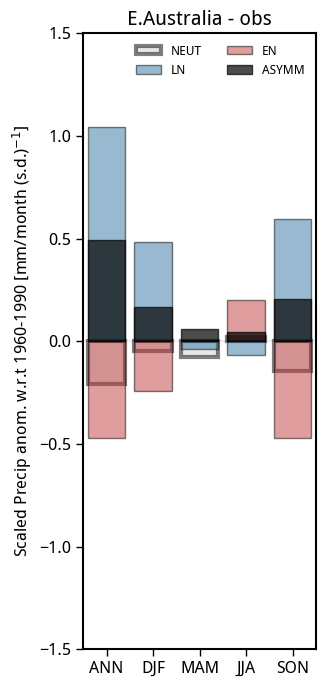

In [280]:
plt.figure(figsize=(3,8))
sns.barplot(data_df, y = 'neut', x = data_df.index, color='lightgray', linewidth=3.0, edgecolor='k', alpha=0.5, label = 'NEUT')
sns.barplot(data_df, y = 'nina', x = data_df.index, color='tab:blue', linewidth=1.0, edgecolor='k', alpha=0.5, label='LN')
sns.barplot(data_df, y = 'nino', x = data_df.index, color='tab:red', linewidth=1.0, edgecolor='k', alpha=0.5, label='EN')
sns.barplot(data_df, y = 'asymm', x = data_df.index, color='k', linewidth=1.0, edgecolor='k', alpha=0.7, label='ASYMM')
plt.ylim(-1.5, 1.5)
plt.axhline(0.0, lw=0.1, color='k')
plt.legend(frameon=False, fontsize=9, ncol=2)
plt.ylabel('Scaled Precip anom. w.r.t 1960-1990 [mm/month (s.d.)$^{-1}$]')
plt.xlabel('')
plt.title(data_df['region'][0] + ' - ' + data_df['model'][0])
# plt.savefig('./PhD/enso_precip_asymmetry/images/pres/eaus_obs_seasonal.png', dpi=300, bbox_inches='tight')

In [72]:
data_df = out_new.isel(season = 0, region = 41).to_dataframe()

In [73]:
data_df.head()

,std_dev,clim,corr_coef,pval,nino,nina,neut,en_events,ln_events,neut_events,threshold,region,season
model,,,,,,,,,,,,,
ACCESS-CM2,16.653444,56.763124,-0.454996,2.878153e-07,-0.684747,0.779973,-0.523573,14.0,16.0,52.0,0.779278,E.Australia,ANN
ACCESS-ESM1-5,17.911413,65.411993,-0.479037,5.335408e-08,-0.650033,0.678421,0.082289,15.0,18.0,46.0,0.818852,E.Australia,ANN
AWI-CM-1-1-MR,10.400973,34.176003,-0.618337,1.406535e-13,-1.042137,0.798994,0.056927,16.0,18.0,50.0,0.907350,E.Australia,ANN
CESM2,19.766763,65.479610,-0.743082,1.293872e-21,-0.665481,1.515502,0.167922,16.0,22.0,46.0,1.211370,E.Australia,ANN
CESM2-WACCM,19.563256,72.134677,-0.628778,4.109036e-14,-0.946722,0.967472,-0.033356,15.0,16.0,55.0,1.132412,E.Australia,ANN


In [74]:
data_df['asymm'] = ((data_df['nino'] - data_df['neut']) + (data_df['nina'] - data_df['neut']))/2

In [75]:
data_df.head()

,std_dev,clim,corr_coef,pval,nino,nina,neut,en_events,ln_events,neut_events,threshold,region,season,asymm
model,,,,,,,,,,,,,,
ACCESS-CM2,16.653444,56.763124,-0.454996,2.878153e-07,-0.684747,0.779973,-0.523573,14.0,16.0,52.0,0.779278,E.Australia,ANN,0.571186
ACCESS-ESM1-5,17.911413,65.411993,-0.479037,5.335408e-08,-0.650033,0.678421,0.082289,15.0,18.0,46.0,0.818852,E.Australia,ANN,-0.068095
AWI-CM-1-1-MR,10.400973,34.176003,-0.618337,1.406535e-13,-1.042137,0.798994,0.056927,16.0,18.0,50.0,0.907350,E.Australia,ANN,-0.178498
CESM2,19.766763,65.479610,-0.743082,1.293872e-21,-0.665481,1.515502,0.167922,16.0,22.0,46.0,1.211370,E.Australia,ANN,0.257088
CESM2-WACCM,19.563256,72.134677,-0.628778,4.109036e-14,-0.946722,0.967472,-0.033356,15.0,16.0,55.0,1.132412,E.Australia,ANN,0.043731


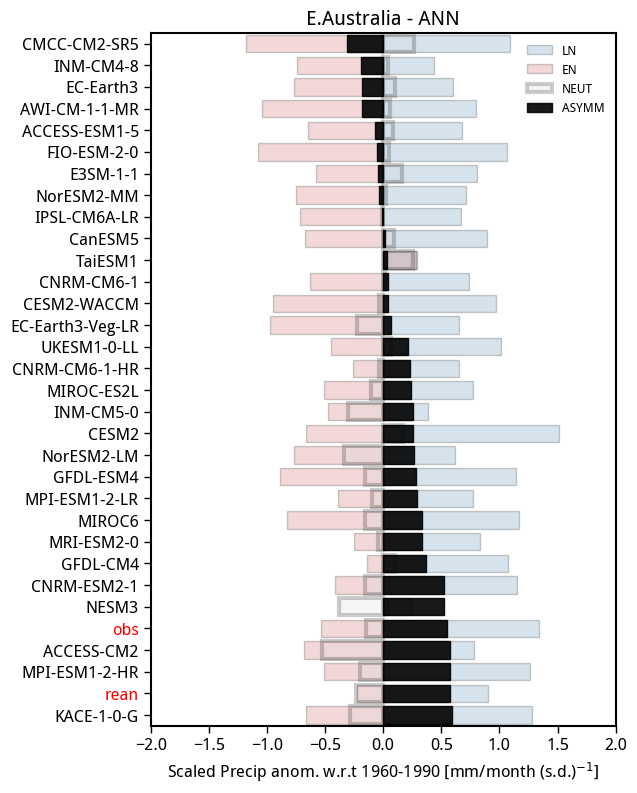

In [78]:
plt.figure(figsize=(6,9))
sns.barplot(data_df.sort_values('asymm'), x = 'nina', y = data_df.sort_values('asymm').index, color='tab:blue', linewidth=1.0, edgecolor='k', alpha=0.2, label='LN')
sns.barplot(data_df.sort_values('asymm'), x = 'nino', y = data_df.sort_values('asymm').index, color='tab:red', linewidth=1.0, edgecolor='k', alpha=0.2, label='EN')
sns.barplot(data_df.sort_values('asymm'), x = 'neut', y = data_df.sort_values('asymm').index, color='lightgray', linewidth=3.0, edgecolor='k', alpha=0.2, label='NEUT')
sns.barplot(data_df.sort_values('asymm'), x = 'asymm', y = data_df.sort_values('asymm').index, color='k', linewidth=1.0, edgecolor='k', alpha=0.9, label = 'ASYMM')
plt.xlim(-2.0, 2.0)
plt.axvline(0.0, lw=0.1, color='k')
plt.legend(frameon=False, fontsize=9, ncol=1)
plt.xlabel('Scaled Precip anom. w.r.t 1960-1990 [mm/month (s.d.)$^{-1}$]')
plt.ylabel('')
plt.title(data_df['region'][0] + ' - ' + data_df['season'][0])
plt.gca().get_yticklabels()[-2].set_color('red')
plt.gca().get_yticklabels()[-5].set_color('red')
# plt.savefig('./PhD/enso_precip_asymmetry/images/pres/eaus_son_model.png', dpi=300, bbox_inches='tight')